---
title: "SHAP values"
execute:
  # echo: false
  freeze: auto  # re-render only when source changes
format:
  html:
    code-fold: true
    code-summary: "Show the code"
---

## simple practical example

Let's say I want to know what impacts the price of a car. I have a model that takes into account 2 features, the car's age ($x_1$) and the car's mileage ($x_2$). In a mathematical notation, we can say that $p$ is the total number of features ($p=2$ in our case), and that $\mathcal{F} = \{x_1, x_2\}$ is the set of all features.

Assume that we have a dataset with $n$ cars, and we somehow arrived at a model $f(x_1, x_2)$ that predicts the price of a car based on its age and mileage. See below a visualization of this model: the predicted price of a car is the color in a 2D space where the axes are age and mileage. The black dots are the cars in our dataset. Don't take the axes and the values too seriously, I just cooked up this example so we have an image in mind while learning about SHAP values.

In [1]:
#| code-summary: "import libraries"
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as colors
# %matplotlib widget

In [2]:
#| code-summary: "model definition and sample data generation"
def model_f(x1, x2):
    return 5 + 0.5 * 0.3*x1**2 + x2 + (0.3 * x1 * x2) + 3*np.exp((-(x1+1)**2 - (x2-1)**2)/0.3) - 3*np.exp((-(x1-1)**2 - (x2+1)**2)/0.3)

N = 40
rng = np.random.default_rng(seed=1)
x1_min = -2; x1_max = 2
x2_min = -2; x2_max = 2
x1_sample = rng.uniform(x1_min, x1_max, size=N)
x2_sample = rng.uniform(x2_min, x2_max, size=N)
z_sample = model_f(x1_sample, x2_sample)

# 2. Create the feature space (The Domain)
x1_range = np.linspace(x1_min, x1_max, 50)
x2_range = np.linspace(x2_min, x2_max, 50)
X1, X2 = np.meshgrid(x1_range, x2_range)
Z = model_f(X1, X2)

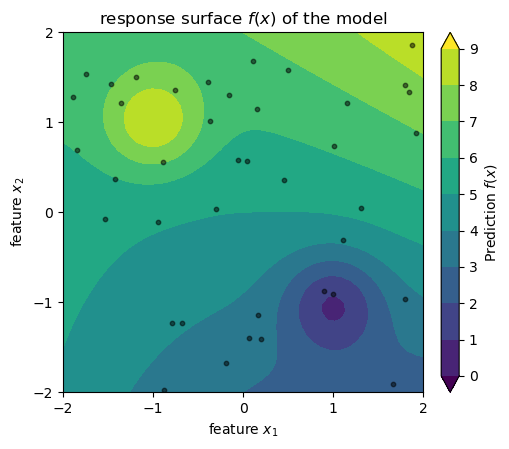

In [3]:
#| code-summary: "2d plot"
fig, ax = plt.subplots(figsize=(6, 6))
fig.subplots_adjust(top=0.90, bottom=0.10, left=0.20, right=0.80)
levels = np.arange(0, 10, 1)
norm = colors.BoundaryNorm(boundaries=levels, ncolors=256, extend='both')
cpax = ax.contourf(X1, X2, Z, levels=levels, cmap=cm.viridis, norm=norm, extend='both')
cax = ax.inset_axes([1.05, 0.0, 0.05, 1.0], transform=ax.transAxes)
cbar = fig.colorbar(cpax, cax=cax)
cbar.set_label(r"Prediction $f(x)$ ")
ax.scatter(x1_sample, x2_sample, c='k', s=10, alpha=0.5, label='Sample Points')
ax.set_aspect('equal')
ax.set(
    xlabel=r"feature $x_1$",
    ylabel=r"feature $x_2$",
    title=r"response surface $f(x)$ of the model",
    xticks=np.arange(-2, 3, 1),
    yticks=np.arange(-2, 3, 1)
);

Now, we want to understand how much each feature contributes to the predicted price for a **specific car** $(x_1^\star, x_2^\star)$ in our dataset. More specifically, we are asking:

**Relative to the average price of all cars in the dataset, how many dollars of this specific car's price can be attributed to its age ($x_1^\star$​) and how many to its mileage ($x_2^\star$)?**

This can be answered by the formula below.

$$
\phi_j = \frac{1}{p} \sum_{S \subseteq \mathcal{F} \setminus \{j\}} \frac{1}{\binom{p-1}{|S|}}[f(S \cup \{j\}) - f(S)].
$$

To compute the SHAP value $\phi_1$ for the car's age ($x_1$), we have to think of all the features except age, and we denote that as $\mathcal{F} \setminus \{x_1\}$. If you are used to the `pandas` lingo, this expression from set theory is just saying "take all feature columns and drop age column", where the operation $\setminus$ represents "drop". In our case, 

$$
\mathcal{F} \setminus \{x_1\} = \{x_1, x_2\} \setminus \{x_1\} = \{x_2\}.
$$

From what's left, we consider all possible subsets or equal to it, which is what $S \subseteq$ is saying. In our case, the subsets of $\{x_2\}$ are the empty set $S_0 = \{\}$, and the set $S_1 = \{x_2\}$. This is what we are summing over in the formula above. Later on, we will see an example with more features, and then we will have more subsets to consider.

The denominator in the fraction is the binomial coefficient, which is a normalization factor that accounts for the number of subsets of a given size. This binomial term ensures all subsets of equal size are weighted equally, and that the total weights sum to 1, satisfying the Shapley axioms (efficiency, symmetry, etc., more on that later).
The quantity $|S|$ represents the size of the subset $S$, that is, the number of features in the subset. In our example, since we have $p-1=1$ feature left in $\mathcal{F} \setminus \{x_1\}=\{x_2\}$, we have $\binom{1}{0} = 1$ for the empty set, $\binom{1}{1} = 1$ for subsets of size 1.

The last part of the formula, $f(S \cup \{j\}) - f(S)$, represents the marginal contribution of feature $x_j$ (here, price $x_1$) when added to the subset $S$. Let's spell it out for our example:

\begin{align*}
\phi_1 &= \frac{1}{2}\binom{1}{0}^{-1}[f(\{x_1\}) - f(\{\})] + \frac{1}{2}\binom{1}{1}^{-1}[f(\{x_1, x_2\}) - f(\{x_2\})] \\
&= \frac{1}{2}\left(\underbrace{[f(\{x_1\}) - f(\{\})]}_{\text{term 1}} + \underbrace{[f(\{x_1, x_2\}) - f(\{x_2\})]}_{\text{term 2}}\right).
\end{align*}

Intuitively, the expression above is asking:

* **Term 1**: How much does the predicted price change when we add the car's age to our model, when we have no other information (the empty set)?
* **Term 2**: How much does the predicted price change when we add the car's age to our model, when we already know the car's mileage?


We need now to find the values of $f(\{\})$, $f(\{x_1\})$, $f(\{x_2\})$, and $f(\{x_1, x_2\})$ to compute $\phi_1$. Let's see what each means:

* $f(\{\})$ is the expected price of a car when we ignore both age and mileage.
* $f(\{x_1\})$ is the expected price of a car when we only consider its age, ignoring mileage.
* $f(\{x_2\})$ is the expected price of a car when we only consider its mileage, ignoring age.
* $f(\{x_1, x_2\})$ is the expected price of a car when we consider both age and mileage.

Let's start with $f(\{\})$. This is the expected price of a car when we ignore both age and mileage. I find it more illuminating to phrase this as a question: **If I have a car, and I don't know its age or milage, what is the expected price based on the typical ages and mileages of cars in my dataset?**
We can compute this by averaging the model's predictions over all possible values of age and mileage:

$$
f(\{\}) = \mathbb{E}[f(x)] = \int f(x_1, x_2) p(x_1, x_2) dx_1 dx_2.
$$

Because we have a finite dataset of $n$ cars, we can approximate this integral by taking the average of the model's predictions for all $n$ cars in our dataset:

$$
f(\{\}) = \frac{1}{n} \sum_{i=1}^{n} f(x_1^i, x_2^i).
$$

Let's visualize this. First, we picture the model's predictions as a surface in a 3D space where the axes are age, mileage, and predicted price.

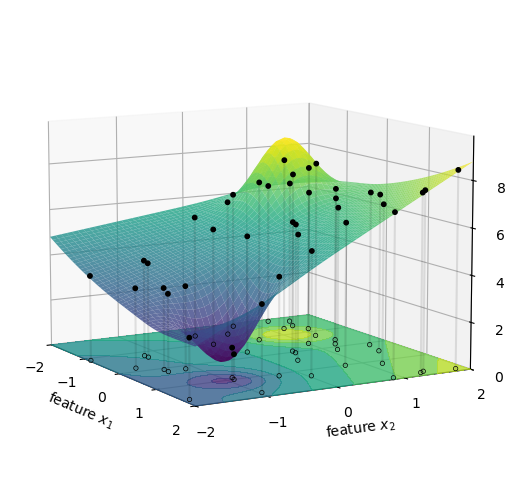

In [4]:
#| code-summary: "3d plot"
fig = plt.figure(figsize=(8, 6))
fig.subplots_adjust(top=0.90, bottom=0.10, left=0.20, right=0.80)
ax = fig.add_subplot(111, projection='3d')
ax.computed_zorder = False
surf = ax.plot_surface(X1, X2, Z, cmap=cm.viridis, alpha=0.8, antialiased=True)
ax.scatter(x1_sample, x2_sample, z_sample, c='k', s=10, alpha=1.0, label='Sample Points')
z_offset = 0
ax.scatter(x1_sample, x2_sample, z_offset, facecolors='none', edgecolors='k', s=10, alpha=1.0, linewidths=0.5)
for i in range(N):
    ax.plot([x1_sample[i]]*2, [x2_sample[i]]*2, [z_offset, z_sample[i]], 'k-', alpha=0.1,)

ax.contourf(X1, X2, Z, 
            levels=levels, 
            cmap=cm.viridis, 
            norm=norm, 
            zdir='z',
            extend='both',
            offset=z_offset, 
            alpha=0.8, zorder=0)

ax.set(xlabel=r'feature $x_1$',
       ylabel=r'feature $x_2$',
       zlabel=r'prediction $f(x)$',
       xticks=np.arange(-2, 3, 1),
       yticks=np.arange(-2, 3, 1),
       xlim=(x1_min, x1_max),
       ylim=(x2_min, x2_max),
       zlim=(z_offset, np.max(Z) + 1)
)
ax.view_init(elev=10, azim=-30, roll=0)

$f(\{\})$ is the average height of all the black dots in the figure above. This is the expected price of a car when we don't know its age or mileage, and use instead the typical ages and mileages of cars in our database. We represent the result as the gray horizontal plane in the figure below.

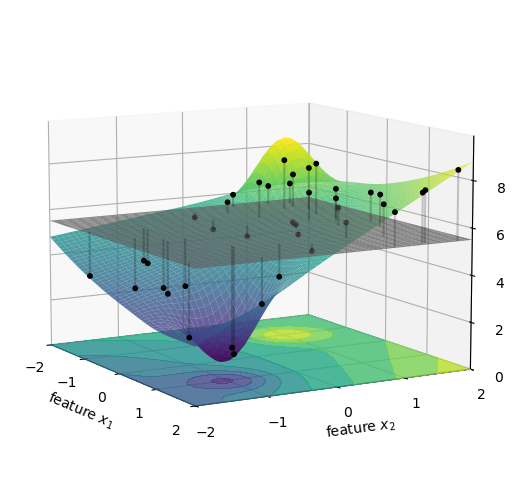

In [5]:
#| code-summary: "3d plot"
fig = plt.figure(figsize=(8, 6))
fig.subplots_adjust(top=0.90, bottom=0.10, left=0.20, right=0.80)
ax = fig.add_subplot(111, projection='3d')
ax.computed_zorder = False
surf = ax.plot_surface(X1, X2, Z, cmap=cm.viridis, alpha=0.8, antialiased=True)
ax.scatter(x1_sample, x2_sample, z_sample, c='k', s=10, alpha=1.0, label='Sample Points')

ax.contourf(X1, X2, Z, 
            levels=levels, 
            cmap=cm.viridis, 
            norm=norm, 
            zdir='z',
            extend='both',
            offset=z_offset, 
            alpha=0.8, zorder=0)

phi_0 = np.mean(z_sample)
surf = ax.plot_surface(X1, X2, np.full_like(Z, phi_0), color="gray", alpha=0.8, antialiased=True)

for i in range(N):
    ax.plot([x1_sample[i]]*2, [x2_sample[i]]*2, [phi_0, z_sample[i]], 'k-', alpha=0.2)

ax.set(xlabel=r'feature $x_1$',
       ylabel=r'feature $x_2$',
       zlabel=r'prediction $f(x)$',
       xticks=np.arange(-2, 3, 1),
       yticks=np.arange(-2, 3, 1),
       xlim=(x1_min, x1_max),
       ylim=(x2_min, x2_max),
       zlim=(z_offset, np.max(Z) + 1)
)
ax.view_init(elev=10, azim=-30, roll=0)

Now let's compute $f(\{x_1\})$. This is the expected price of a specific car when we only consider its age, ignoring mileage. Phrasing this as a question: **If I have a 5-year-old car, but I don't know its mileage, what is its expected price based on the typical mileages I see in my data?**

In integral form, this can be expressed as:

$$
f(\{x_1\}) = \mathbb{E}[f(x) | x_1] = \int f(x_1, x_2) p(x_2) dx_2.
$$

We can compute this by averaging the model's predictions over all possible values of mileage, while keeping age fixed:

$$
f(\{x_1\}) = \frac{1}{n} \sum_{i=1}^{n} f(x_1^\star, x_2^i),
$$
where $x_1^\star$ is the age of the specific car we are trying to explain, and $x_2^i$ are the mileages of all cars in our dataset.

**Attention!** In the integral equation I made a simplifying assumption, one that I will come back to later. At this stage, it suffices to mention that I initially had to compute the conditional expectation, and I exchanged that for a simpler marginal expectation. I just wanted to plant this flag now, and I will explain the difference between the two later in this chapter.

Let's visualize this. The figure below shows a specific car in our dataset as a red dot. The pink vertical plane is located at the age of this car, and we marked the intersection of this plane with the surface as a red curve. All the black dots, previously located at their original age and mileage, were brought to this pink plane. We did that just by shifting their $x_1$ value to $x_1^\star$, while keeping their $x_2$ and $z$ values the same. I imagine this as squishing the dots along the $x_1$ axis, until they all lie on the pink plane.

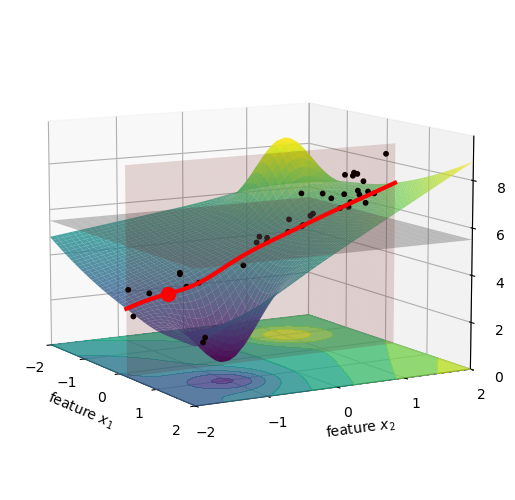

In [6]:
#| code-summary: "3d plot"
fig = plt.figure(figsize=(8, 6))
fig.subplots_adjust(top=0.90, bottom=0.10, left=0.20, right=0.80)
ax = fig.add_subplot(111, projection='3d')
ax.computed_zorder = False
surf = ax.plot_surface(X1, X2, Z, cmap=cm.viridis, alpha=0.8, antialiased=True)
idx = 8

ax.scatter(np.full_like(x1_sample, x1_sample[idx]), x2_sample, z_sample, c='k', s=10, alpha=1.0, label='Sample Points')

ax.contourf(X1, X2, Z, 
            levels=levels, 
            cmap=cm.viridis, 
            norm=norm, 
            zdir='z',
            extend='both',
            offset=z_offset, 
            alpha=0.8, zorder=0)

x1_star = x1_sample[idx]
x2_star = x2_sample[idx]
z_star = z_sample[idx]
slice_x2 = np.linspace(-2, 2, 100)
slice_x1 = np.full_like(slice_x2, x1_star)
slice_z = model_f(slice_x1, slice_x2)
ax.plot(slice_x1, slice_x2, slice_z, color='red', linewidth=3, label='Slice for f_x({x1})')

# Plot the specific prediction point (y_hat)
ax.scatter([x1_sample[idx]], [x2_sample[idx]], [z_sample[idx]], color='red', s=100, label='Prediction (y_hat)', zorder=10)

phi_0 = np.mean(z_sample)
surf = ax.plot_surface(X1, X2, np.full_like(Z, phi_0), color="gray", alpha=0.4, antialiased=True)

z_plane_range = np.linspace(z_offset, np.max(Z), 10)
slice_x2_mesh, z_mesh = np.meshgrid(slice_x2, z_plane_range)
slice_x1_mesh = np.full_like(slice_x2_mesh, x1_star)
ax.plot_surface(slice_x1_mesh, slice_x2_mesh, z_mesh, 
                color='red', alpha=0.15, zorder=1)

ax.set(xlabel=r'feature $x_1$',
       ylabel=r'feature $x_2$',
       zlabel=r'prediction $f(x)$',
       xticks=np.arange(-2, 3, 1),
       yticks=np.arange(-2, 3, 1),
       xlim=(x1_min, x1_max),
       ylim=(x2_min, x2_max),
       zlim=(z_offset, np.max(Z) + 1)
)
ax.view_init(elev=10, azim=-30, roll=0)



Now we compute the values for $f(x_1^\star, x_2^i)$. This is the same as taking all the black dots in the figure above, and moving them vertically to the red line, see below.

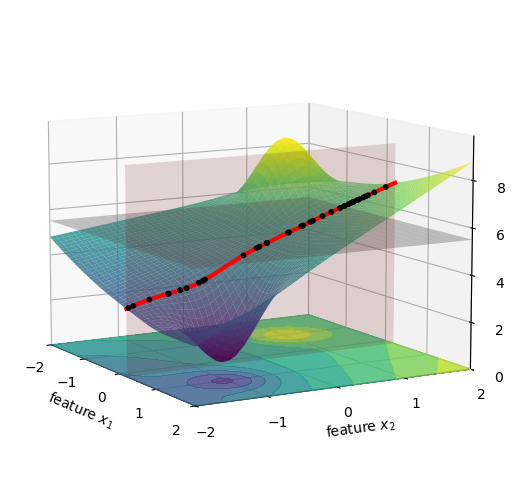

In [7]:
#| code-summary: "3d plot"
fig = plt.figure(figsize=(8, 6))
fig.subplots_adjust(top=0.90, bottom=0.10, left=0.20, right=0.80)
ax = fig.add_subplot(111, projection='3d')
ax.computed_zorder = False
surf = ax.plot_surface(X1, X2, Z, cmap=cm.viridis, alpha=0.8, antialiased=True)
x1_squished = np.full_like(x1_sample, x1_sample[idx])
ax.scatter(x1_squished, x2_sample, model_f(x1_squished, x2_sample), c='k', s=10, alpha=1.0, zorder=11)

ax.contourf(X1, X2, Z, 
            levels=levels, 
            cmap=cm.viridis, 
            norm=norm, 
            zdir='z',
            extend='both',
            offset=z_offset, 
            alpha=0.8, zorder=0)

x1_star = x1_sample[idx]
x2_star = x2_sample[idx]
z_star = z_sample[idx]
slice_x2 = np.linspace(-2, 2, 100)
slice_x1 = np.full_like(slice_x2, x1_star)
slice_z = model_f(slice_x1, slice_x2)
ax.plot(slice_x1, slice_x2, slice_z, color='red', linewidth=3, label='Slice for f_x({x1})')

phi_0 = np.mean(z_sample)
surf = ax.plot_surface(X1, X2, np.full_like(Z, phi_0), color="gray", alpha=0.4, antialiased=True)

z_plane_range = np.linspace(z_offset, np.max(Z), 10)
slice_x2_mesh, z_mesh = np.meshgrid(slice_x2, z_plane_range)
slice_x1_mesh = np.full_like(slice_x2_mesh, x1_star)
ax.plot_surface(slice_x1_mesh, slice_x2_mesh, z_mesh, 
                color='red', alpha=0.15, zorder=1)

ax.set(xlabel=r'feature $x_1$',
       ylabel=r'feature $x_2$',
       zlabel=r'prediction $f(x)$',
       xticks=np.arange(-2, 3, 1),
       yticks=np.arange(-2, 3, 1),
       xlim=(x1_min, x1_max),
       ylim=(x2_min, x2_max),
       zlim=(z_offset, np.max(Z) + 1)
)
ax.view_init(elev=10, azim=-30, roll=0)

We can average the height of all these new black dots, which is shown below as a black horizontal line, and this will give us the value of $f(\{x_1\})$.

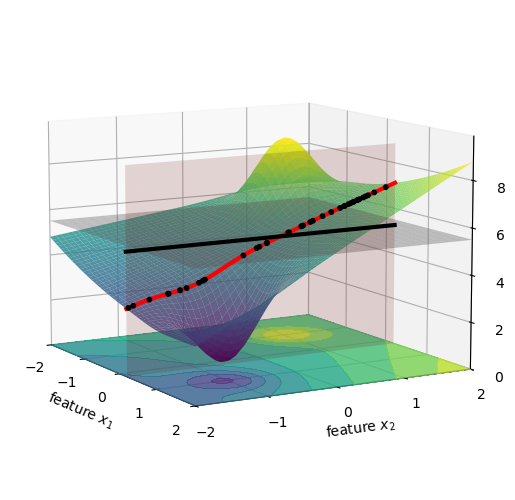

In [8]:
#| code-summary: "3d plot"
fig = plt.figure(figsize=(8, 6))
fig.subplots_adjust(top=0.90, bottom=0.10, left=0.20, right=0.80)
ax = fig.add_subplot(111, projection='3d')
ax.computed_zorder = False
surf = ax.plot_surface(X1, X2, Z, cmap=cm.viridis, alpha=0.8, antialiased=True)
x1_squished = np.full_like(x1_sample, x1_sample[idx])
x2_squished = np.full_like(x2_sample, x2_sample[idx])
z_x1squished = model_f(x1_squished, x2_sample)
z_x2squished = model_f(x1_sample, x2_squished)
ax.scatter(x1_squished, x2_sample, z_x1squished, c='k', s=10, alpha=1.0, zorder=11)

z_x1 = np.mean(z_x1squished)
z_x2 = np.mean(z_x2squished)

ax.contourf(X1, X2, Z, 
            levels=levels, 
            cmap=cm.viridis, 
            norm=norm, 
            zdir='z',
            extend='both',
            offset=z_offset, 
            alpha=0.8, zorder=0)

x1_star = x1_sample[idx]
x2_star = x2_sample[idx]
z_star = z_sample[idx]
slice_x2 = np.linspace(-2, 2, 100)
slice_x1 = np.full_like(slice_x2, x1_star)
slice_z = model_f(slice_x1, slice_x2)
ax.plot(slice_x1, slice_x2, slice_z, color='red', linewidth=3, label='Slice for f_x({x1})')
ax.plot(slice_x1, slice_x2, np.full_like(slice_x2, z_x1), color='black', linewidth=3)

phi_0 = np.mean(z_sample)
surf = ax.plot_surface(X1, X2, np.full_like(Z, phi_0), color="gray", alpha=0.4, antialiased=True)

z_plane_range = np.linspace(z_offset, np.max(Z), 10)
slice_x2_mesh, z_mesh = np.meshgrid(slice_x2, z_plane_range)
slice_x1_mesh = np.full_like(slice_x2_mesh, x1_star)
ax.plot_surface(slice_x1_mesh, slice_x2_mesh, z_mesh, 
                color='red', alpha=0.15, zorder=1)

ax.set(xlabel=r'feature $x_1$',
       ylabel=r'feature $x_2$',
       zlabel=r'prediction $f(x)$',
       xticks=np.arange(-2, 3, 1),
       yticks=np.arange(-2, 3, 1),
       xlim=(x1_min, x1_max),
       ylim=(x2_min, x2_max),
       zlim=(z_offset, np.max(Z) + 1)
)
ax.view_init(elev=10, azim=-30, roll=0)

We are now ready to compute the first term for $\phi_1$, namely $f(\{x_1\}) - f(\{\})$. Visually, this is the distance between the black horizontal line and the gray horizontal plane in the figure above. This value is not very large, so we just can't quite see it in the figure, but it's there. We print its value below:

In [21]:
first_term = (z_x1 - phi_0) / 2
print(f"{first_term:.3f}")

-0.122


Next, we compute $f(\{x_2\})$. This is the expected price of a specific car when we only consider its mileage, ignoring age. Phrasing this as a question: **If I have a car with 100,000 miles, but I don't know its age, what is its expected price based on the typical ages I see in my data?**

In integral form, this can be expressed as:

$$
f(\{x_2\}) = \mathbb{E}[f(x) | x_2] = \int f(x_1, x_2) p(x_1) dx_1.
$$

Similarly to what I did for $f(\{x_1\})$, here too I replaced the conditional expectation with a marginal expectation. I did not forget to comment on this, I'll do it in a little while. Let's keep going.

We can compute this by averaging the model's predictions over all possible values of age, while keeping mileage fixed:

$$
f(\{x_2\}) = \frac{1}{n} \sum_{i=1}^{n} f(x_1^i, x_2^\star),
$$
where $x_2^\star$ is the mileage of the specific car we are trying to explain, and $x_1^i$ are the ages of all cars in our database.

Visually, this is almost the same as what we did in the figures above for $x_1$, but now on the other axis.

Finally, we compute $f(\{x_1, x_2\})$. This is the expected price of a specific car when we consider both age and mileage. Phrasing this as a question: **If I have a 5-year-old car with 100,000 miles, what does my model predict its price to be?**

The expectation operator now becomes trivial:
$$
f(\{x_1, x_2\}) = \mathbb{E}[f(x) | x_1, x_2] = f(x_1^\star, x_2^\star).
$$

Since we are conditioning on both age and mileage, we can directly use the model's prediction for the specific car we are trying to explain, which is $f(x_1^\star, x_2^\star)$.

Now we are ready to compute the second term for $\phi_1$, namely $f(\{x_1, x_2\}) - f(\{x_2\})$. Visually, it is the vertical distance between the black horizontal line and the actual height of the car we are trying to explain, which is the blue dot in the figure above. We print its value below:

In [22]:
second_term = (model_f(x1_sample[idx], x2_sample[idx]) - z_x2) / 2
print(f"{second_term:.3f}")

-0.073


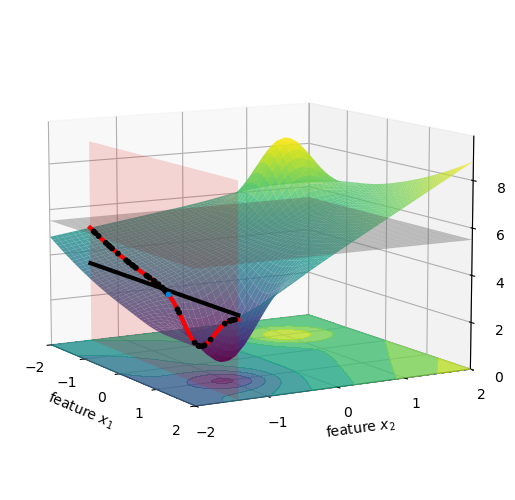

In [11]:
#| code-summary: "3d plot"
fig = plt.figure(figsize=(8, 6))
fig.subplots_adjust(top=0.90, bottom=0.10, left=0.20, right=0.80)
ax = fig.add_subplot(111, projection='3d')
ax.computed_zorder = False
surf = ax.plot_surface(X1, X2, Z, cmap=cm.viridis, alpha=0.8, antialiased=True)
x1_squished = np.full_like(x1_sample, x1_sample[idx])
x2_squished = np.full_like(x2_sample, x2_sample[idx])
z_x1squished = model_f(x1_squished, x2_sample)
z_x2squished = model_f(x1_sample, x2_squished)
ax.scatter(x1_sample, x2_squished, z_x2squished, c='k', s=10, alpha=1.0, zorder=11)
ax.scatter(x1_sample[idx], x2_sample[idx], z_sample[idx], c='xkcd:cerulean', s=10, alpha=1.0, zorder=12)

z_x1 = np.mean(z_x1squished)
z_x2 = np.mean(z_x2squished)

ax.contourf(X1, X2, Z, 
            levels=levels, 
            cmap=cm.viridis, 
            norm=norm, 
            zdir='z',
            extend='both',
            offset=z_offset, 
            alpha=0.8, zorder=0)

x1_star = x1_sample[idx]
x2_star = x2_sample[idx]
z_star = z_sample[idx]
slice_x1 = np.linspace(-2, 2, 100)
slice_x2 = np.full_like(slice_x1, x2_star)
slice_z = model_f(slice_x1, slice_x2)
ax.plot(slice_x1, slice_x2, slice_z, color='red', linewidth=3, label='Slice for f_x({x2})')
ax.plot(slice_x1, slice_x2, np.full_like(slice_x2, z_x2), color='black', linewidth=3)

phi_0 = np.mean(z_sample)
surf = ax.plot_surface(X1, X2, np.full_like(Z, phi_0), color="gray", alpha=0.4, antialiased=True)

z_plane_range = np.linspace(z_offset, np.max(Z), 10)
slice_x1_mesh, z_mesh = np.meshgrid(slice_x1, z_plane_range)
slice_x2_mesh = np.full_like(slice_x1_mesh, x2_star)
ax.plot_surface(slice_x1_mesh, slice_x2_mesh, z_mesh, 
                color='red', alpha=0.15, zorder=1)

ax.set(xlabel=r'feature $x_1$',
       ylabel=r'feature $x_2$',
       zlabel=r'prediction $f(x)$',
       xticks=np.arange(-2, 3, 1),
       yticks=np.arange(-2, 3, 1),
       xlim=(x1_min, x1_max),
       ylim=(x2_min, x2_max),
       zlim=(z_offset, np.max(Z) + 1)
)
ax.view_init(elev=10, azim=-30, roll=0)

Finally, we can compute $\phi_1$ by summing the two terms we just computed:

In [23]:
phi_1 = first_term + second_term
print(f"phi_1 = {phi_1:.3f}")

phi_1 = -0.195


If you read all the code above that produced the figures, you might think that the computation is convoluted. Nothing could be further from the truth. See below the whole thing:

In [24]:
E_empty = np.mean(z_sample)
E_x1 = np.mean(model_f(x1_sample[idx], x2_sample))
E_x2 = np.mean(model_f(x1_sample, x2_sample[idx]))
E_x1x2 = model_f(x1_sample[idx], x2_sample[idx])
phi_1b = ((E_x1 - E_empty) + (E_x1x2 - E_x2)) / 2
phi_2 = ((E_x2 - E_empty) + (E_x1x2 - E_x1)) / 2
print(f"phi_1 = {phi_1b:.3f}")
print(f"phi_2 = {phi_2:.3f}")

phi_1 = -0.195
phi_2 = -2.004


The computation is so trivial that I can do it for the whole dataset and visualize the SHAP values for all cars in my database, as shown below. See a beeswarm plot of the SHAP values that I calculated.

In [25]:
phi1_list = []
phi2_list = []
for i in range(N):
    E_empty = np.mean(z_sample)
    E_x1 = np.mean(model_f(x1_sample[i], x2_sample))
    E_x2 = np.mean(model_f(x1_sample, x2_sample[i]))
    E_x1x2 = model_f(x1_sample[i], x2_sample[i])
    phi_1b = ((E_x1 - E_empty) + (E_x1x2 - E_x2)) / 2
    phi_2 = ((E_x2 - E_empty) + (E_x1x2 - E_x1)) / 2
    phi1_list.append(phi_1b)
    phi2_list.append(phi_2)

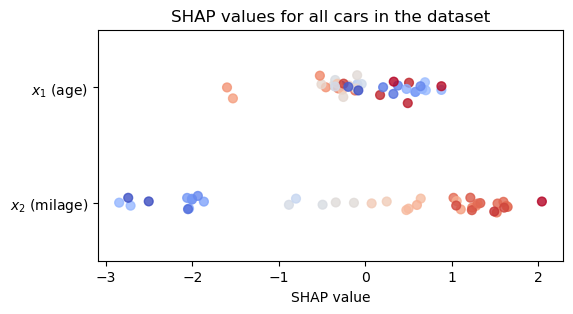

In [37]:
fig, ax = plt.subplots(figsize=(6, 3))
rng = np.random.default_rng(seed=1)
vertical_jitter = rng.normal(0, 0.05, size=N)
# vabs1 = np.max(np.abs(phi1_list))
# vabs2 = np.max(np.abs(phi2_list))
v1max = np.max(x1_sample)
v1min = np.min(x1_sample)
v2max = np.max(x2_sample)
v2min = np.min(x2_sample)
# phi1_norm = colors.TwoSlopeNorm(vmin=-vabs1, vcenter=0, vmax=vabs1)
# phi2_norm = colors.TwoSlopeNorm(vmin=-vabs2, vcenter=0, vmax=vabs2)
x1_norm = colors.TwoSlopeNorm(vmin=v1min, vcenter=0, vmax=v1max)
x2_norm = colors.TwoSlopeNorm(vmin=v2min, vcenter=0, vmax=v2max)

sc = ax.scatter(
    phi1_list,
    1 + vertical_jitter,
    c=x1_sample,
    cmap='coolwarm',
    norm=x1_norm,
    alpha=0.8,
    s=40,
    label='SHAP value for $x_1$ (age)'
)
# fig.colorbar(sc, ax=ax, label=r'$\phi_1$')
vertical_jitter = rng.normal(0, 0.05, size=N)
sc = ax.scatter(
    phi2_list,
    0 + vertical_jitter,
    c=x2_sample,
    cmap='coolwarm',
    norm=x2_norm,
    alpha=0.8,
    s=40,
    label='SHAP value for $x_2$ (income)'
)
ax.set(ylim=(-0.5, 1.5),
       xlabel=r'SHAP value',
       title='SHAP values for all cars in the dataset',
       yticks=[0, 1],
       yticklabels=['$x_2$ (milage)', '$x_1$ (age)']);


Computing SHAP values "by hand" was fun, but in practice we use libraries like `shap` that do all the heavy lifting for us. See how `shap` results (top panel) compare to the values we computed by hand (bottom).

In [19]:
import shap
import pandas as pd

def model_f2(X):
    x1 = X['x1'].values
    x2 = X['x2'].values
    
    return (5 + 0.5 * 0.3 * x1**2 + x2 + (0.3 * x1 * x2) + 
            3 * np.exp((-(x1 + 1)**2 - (x2 - 1)**2) / 0.3) - 
            3 * np.exp((-(x1 - 1)**2 - (x2 + 1)**2) / 0.3))

X = pd.DataFrame({'x1': x1_sample, 'x2': x2_sample})
model = model_f2
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

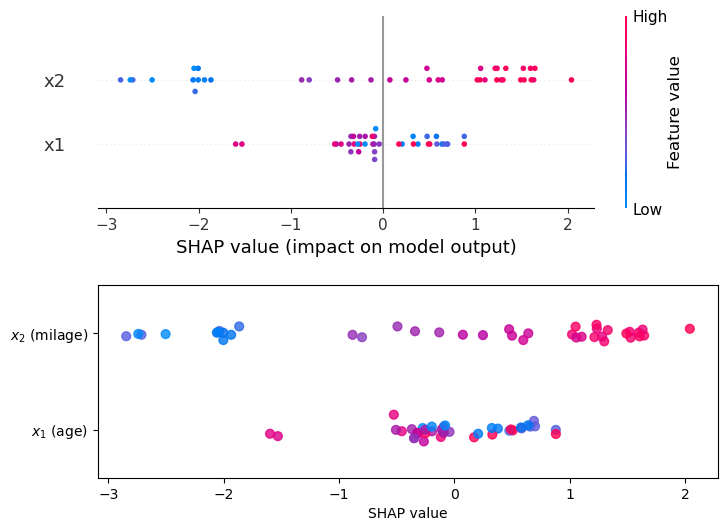

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(8,6))
plt.subplots_adjust(hspace=0.4)
shap.plots.beeswarm(shap_values, ax=ax[0], plot_size=None, show=False)

shap_cmap = shap.plots.colors.red_blue

sc = ax[1].scatter(
    phi1_list,
    0 + vertical_jitter,
    c=x1_sample,
    cmap=shap_cmap,
    norm=x1_norm,
    alpha=0.8,
    s=40,
    label='SHAP value for $x_1$ (age)'
)
vertical_jitter = rng.normal(0, 0.05, size=N)
sc = ax[1].scatter(
    phi2_list,
    1 + vertical_jitter,
    c=x2_sample,
    cmap=shap_cmap,
    norm=x2_norm,
    alpha=0.8,
    s=40,
    label='SHAP value for $x_2$ (income)'
)
ax[1].set(ylim=(-0.5, 1.5),
       xlabel=r'SHAP value',
       yticks=[0, 1],
       yticklabels=['$x_1$ (age)', '$x_2$ (milage)']);



## conditional vs. marginal expectations

In the calculation for $\phi_1$ we had to compute $f(\{x_1\})$, that is, the expected price of a car whose age is known but its milage is unknown. We need to define what prediction we shall assign in this case. We have two options.

### marginal expectation

We will treat the missing feature (milage) as a random draw from the overall empirical milage distribution. The steps are:

1. Freeze the car's age: $x_1=x_1^\star$.
2. Now we compute the model's prediction for the price of the car drawing $x_2$ from all $x_2$ values seen in the dataset, and then average them. 

Mathematically, we are computing

$$
f(\{x_1\}) = \int f(x_1^\star, x_2) p(x_2) dx_2.
$$

We are weighing the car prices $f$ according to the distribution in $x_2$.

There's a problem here. Assume that our car is 15 years old, that is, $x_1^\star=15$. This means that when computing $f(x_1^\star,x_2)$, we will plug into it a bunch of values for low-milage cars. To make this point sharper, assume that 20% of the cars in our dataset have milage below 20k miles. This means that in our estimation of $f(\{x_1\})$, 20% of the estimated prices are for 15-year-old cars with an extremely low milage. That's absurd! It's extremely rare that such cars exist, how can we not take into account the age of the car here? Well, if we want to do better, then we shouldn't be using the marginal expectation, we should be using the conditional expectation.

### conditional expectation

Now, the random drawing of values for the milage is age-aware.

1. Freeze the car's age: $x_1=x_1^\star$.
2. Now we average the prediction over milage values $x_2$ that are typical of 15-year-old cars.

Mathematically, this reads

$$
f(\{x_1\}) = \int f(x_1^\star, x_2) p(x_2 \mid x_1^\star) dx_2.
$$

Great! That makes a lot more sense! So why don't we use conditional expectation every time? The reason is that it is much harder to compute. To compute the conditional expectation $p(x_2 \mid x_1^\star)$ we need to estimate the joint distribution $p(x_1^\star, x_2)$, since

$$
p(x_2 \mid x_1^\star) = \frac{p(x_1^\star, x_2)}{p(x_1^\star)}.
$$

If our dataset is small, the region of the feature space where $x_1^\star$ is located might be very sparse, and we won't have enough data to estimate $p(x_2 \mid x_1^\star)$ accurately. Another problem arises in high-dimensional data, where we have many features. If we had 10 features instead of 2, and we wanted to compute the SHAP value for one of them, we would need to estimate the conditional distribution of that feature given the other 9 features. This is a much more complex task than estimating the marginal distribution of a single feature, one that would require an extremely large number of samples, which we often don't have.

### the hidden assumption

When is it ok to substitute the conditional expectation with the marginal expectation? The answer is when the features are independent. If $x_1$ and $x_2$ are independent, then
$$
p(x_1, x_2) = p(x_1)p(x_2).
$$

From the definition of conditional probability, we have
$$
p(x_1, x_2) = p(x_2 \mid x_1)p(x_1)
$$

Equating the two expressions above, we get
$$
p(x_2 \mid x_1) = p(x_2).
$$

And that is exactly the substitution we made: we replaced the conditional expectation with the marginal expectation.

Whenever my features are independent, or at least weakly correlated, I can safely use the marginal expectation to compute SHAP values. If some of my features are correlated, then depending on the problem I might find tools that can estimate the conditional expectation, such as `shap.TreeExplainer` for tree-based models.

I won't go into the details, but some of the quirks of erroneously using the marginal expectation when the features are correlated are:

* Credit gets arbitrarily redistributed between correlated features.
* The SHAP values of correlated features might have flipped sign.
* SHAP takes into consideration unrealistic feature combinations, which can lead to unreliable explanations.

## more than 2 features

The simple example of the car price took us quite far in understanding the basics of SHAP values. I'll just add for completeness what happens when we have more than 2 features. Let's assume a model $f$ with 5 features ($p=5$), and we want to compute the SHAP value for feature $x_1$. The set of all features is $\mathcal{F} = \{x_1, x_2, x_3, x_4, x_5\}$, and the set of all features except $x_1$ is $\mathcal{F} \setminus \{x_1\} = \{x_2, x_3, x_4, x_5\}$. The subsets of $\mathcal{F} \setminus \{x_1\}$ are:

* $S_0 = \{\}$ (the empty set)
* $S_1 = \{x_2\}$
* $S_2 = \{x_3\}$
* $S_3 = \{x_4\}$
* $S_4 = \{x_5\}$
* $S_5 = \{x_2, x_3\}$
* $S_6 = \{x_2, x_4\}$
* $S_7 = \{x_2, x_5\}$
* $S_8 = \{x_3, x_4\}$
* $S_9 = \{x_3, x_5\}$
* $S_{10} = \{x_4, x_5\}$
* $S_{11} = \{x_2, x_3, x_4\}$
* $S_{12} = \{x_2, x_3, x_5\}$
* $S_{13} = \{x_2, x_4, x_5\}$
* $S_{14} = \{x_3, x_4, x_5\}$
* $S_{15} = \{x_2, x_3, x_4, x_5\}$

See how the number of subsets grows exponentially with the number of features. For a model with $p$ features, we have $2^{p-1}$ subsets to consider when computing the SHAP value for a single feature. The formula for $\phi_1$ in this case would be:

\begin{align*}
5\phi_1 &=
\binom{4}{0}^{-1}[f(\{x_1\}) - f(\{\})] +
\binom{4}{1}^{-1}[f(\{x_1, x_2\}) - f(\{x_2\})]
\\
&+ \binom{4}{1}^{-1}[f(\{x_1, x_3\}) - f(\{x_3\})]
+ \binom{4}{1}^{-1}[f(\{x_1, x_4\}) - f(\{x_4\})]
\\
&+ \binom{4}{1}^{-1}[f(\{x_1, x_5\}) - f(\{x_5\})]
+ \binom{4}{2}^{-1}[f(\{x_1, x_2, x_3\}) - f(\{x_2, x_3\})]
\\
&+ \binom{4}{2}^{-1}[f(\{x_1, x_2, x_4\}) - f(\{x_2, x_4\})]
+ \binom{4}{2}^{-1}[f(\{x_1, x_2, x_5\}) - f(\{x_2, x_5\})]
\\
&+ \binom{4}{2}^{-1}[f(\{x_1, x_3, x_4\}) - f(\{x_3, x_4\})]
+ \binom{4}{2}^{-1}[f(\{x_1, x_3, x_5\}) - f(\{x_3, x_5\})]
\\
&+ \binom{4}{2}^{-1}[f(\{x_1, x_4, x_5\}) - f(\{x_4, x_5\})]
+ \binom{4}{3}^{-1}[f(\{x_1, x_2, x_3, x_4\}) - f(\{x_2, x_3, x_4\})]
\\
&+ \binom{4}{3}^{-1}[f(\{x_1, x_2, x_3, x_5\}) - f(\{x_2, x_3, x_5\})]
+ \binom{4}{3}^{-1}[f(\{x_1, x_2, x_4, x_5\}) - f(\{x_2, x_4, x_5\})]
\\
&+ \binom{4}{3}^{-1}[f(\{x_1, x_3, x_4, x_5\}) - f(\{x_3, x_4, x_5\})]
+ \binom{4}{4}^{-1}[f(\{x_1, x_2, x_3, x_4, x_5\}) - f(\{x_2, x_3, x_4, x_5\})].
\end{align*}

What a delight it would be to calculate that by hand!

One of the terms we need to compute is $f(\{x_1, x_3, x_4\})$, which reads

$$
f(\{x_1, x_3, x_4\}) = \int f(x_1, x_2, x_3, x_4, x_5) p(x_2, x_5 \mid x_1, x_3, x_4) dx_2 dx_5.
$$

Using the marginal expectation instead of the conditional expectation, we would compute

$$
f(\{x_1, x_3, x_4\}) = \int f(x_1, x_2, x_3, x_4, x_5) p(x_2) p(x_5) dx_2 dx_5,
$$

which numerically translates into

$$
f(\{x_1, x_3, x_4\}) = \frac{1}{n^2} \sum_{i=1}^{n} \sum_{j=1}^{n} f(x_1^\star, x_2^i, x_3^\star, x_4^\star, x_5^j).
$$

There is not much I can learn from an example with more than 2 features, othen than the fact that there are many combinations to consider, but essentially each term is still conceptually the same.

## unfinished

* Now I need to discuss the general case, when we have more than 2 features.
* Discuss the properties of SHAP values, show its decomposition.
* Show how to compute SHAP in python.


A useful way to understant the usefulness of SHAP values is by the SHAP decomposition. If $f(x)$ is the model's prediction for a specific data point $x$, the decomposition is:

$$
f(x) = \phi_0 + \sum_{j=1}^n \phi_j,
$$

where we have $M$ features. The SHAP values $\phi_j$ represent the contribution of each feature to the prediction, beyond the average prediction $\phi_0$.